# All plots

## Time difference between AE, PS and S2

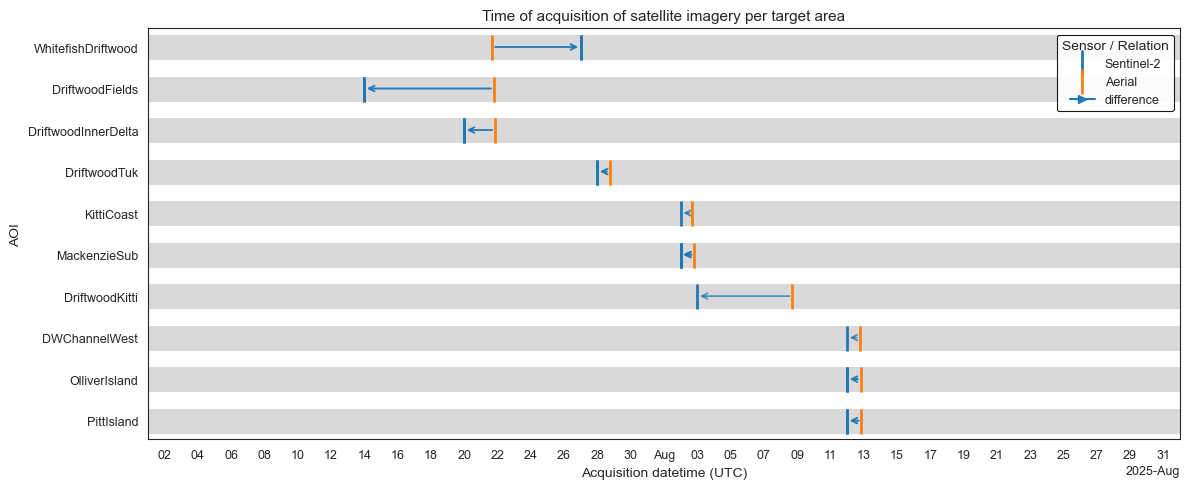


Time difference between consecutive acquisitions per AOI (hours):
                AOI  count  mean_hours  median_hours  min_hours  max_hours
      DWChannelWest      1       17.95         17.95      17.95      17.95
    DriftwoodFields      2       93.25         93.25       0.00     186.50
DriftwoodInnerDelta      2       22.02         22.02       0.00      44.03
     DriftwoodKitti      1      136.93        136.93     136.93     136.93
       DriftwoodTuk      2        8.94          8.94       0.00      17.88
         KittiCoast      1       16.70         16.70      16.70      16.70
       MackenzieSub      3        6.53          0.00       0.00      19.60
      OlliverIsland      2        9.83          9.83       0.00      19.67
         PittIsland      2       10.32         10.32       0.00      20.65
 WhitefishDriftwood      2       63.67         63.67       0.00     127.33

OVERALL time difference between consecutive acquisitions (hours):
count     18.00
mean      33.74
median   

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import geopandas as gpd
import matplotlib.lines as mlines   # <<< for arrow legend proxy

# --- Load ---
csv_path = r"\\smb.isipd.dmawi.de\projects\p_planetdw\data\methods_test\aois\S2_GEE_export_summary.csv"
gpkg_path = r"\\smb.isipd.dmawi.de\projects\p_planetdw\data\methods_test\auxilliary_data\aoi_ext.gpkg"

df = pd.read_csv(csv_path)

# Only need attributes (layer, target_name, time)
aerialaq = gpd.read_file(gpkg_path, ignore_geometry=True)

# --- Aerial: build full datetime (date from 'layer', time from 'time' column) ---

# Date from layer: 3rd part, YYYYMMDD
aerialaq["Date"] = aerialaq["layer"].str.split("_").str[2]
aerialaq["Date"] = pd.to_datetime(aerialaq["Date"], format="%Y%m%d", errors="coerce")

# Time string (Zulu HH:MM)
aerialaq["time"] = aerialaq["time"].astype(str).str.strip()

# Combine date + time into full datetime, then make it naive UTC (no tz info)
aerialaq["DateTime"] = pd.to_datetime(
    aerialaq["Date"].dt.strftime("%Y-%m-%d") + " " + aerialaq["time"],
    utc=True,
    errors="coerce",
).dt.tz_convert(None)

# --- Sentinel (and others): parse datetime with time-of-day ---
df["Date"] = pd.to_datetime(df["Date"], utc=True, errors="coerce").dt.tz_convert(None)

# Make sure DateDeltaDays is numeric (kept for cleanliness, not used for Aerial)
df["DateDeltaDays"] = pd.to_numeric(df.get("DateDeltaDays", 0), errors="coerce").fillna(0)

# --- Infer Sensor if not present ---
def infer_sensor(row):
    s = " ".join(str(row.get(c, "")) for c in ["ExportTask", "SystemIndex"]).upper()
    if ("_AE" in s) or ("AE_" in s) or (" AE " in s):
        return "AE"
    if "AERIAL" in s:
        return "Aerial"
    if ("S2" in s) or ("SENTINEL-2" in s) or ("SENTINEL2" in s):
        return "Sentinel-2"
    return "Other"

if "Sensor" not in df.columns:
    df["Sensor"] = df.apply(infer_sensor, axis=1)

# --- Drop Aerial coming from the CSV: only use Aerial from GPKG ---
df = df[df["Sensor"] != "Aerial"].copy()

# --- Plot-time date for each row ---
df["plot_date"] = df["Date"]

# --- Window: fixed for all AOIs ---
window_start = pd.Timestamp("2025-07-01 00:00")
window_end   = pd.Timestamp("2025-08-31 23:59")

# Keep only markers that fall inside the window
df_plot = df[df["plot_date"].between(window_start, window_end)].copy()

# --- Aerial AOI points (from GPKG) within window ---
aerial_points = aerialaq[aerialaq["DateTime"].between(window_start, window_end)].copy()
aerial_points["Sensor"] = "Aerial"

# --- AOI layout ordered by earliest aerial time (earliest at top) ---

# AOIs that appear in the Sentinel/AE table (what we actually plot on y-axis)
aois_in_plot = df_plot["AOI"].dropna().unique()

# Earliest aerial time per AOI (only for AOIs we plot)
aerial_min = (
    aerial_points[aerial_points["target_name"].isin(aois_in_plot)]
    .dropna(subset=["DateTime", "target_name"])
    .groupby("target_name")["DateTime"]
    .min()
)

# AOIs that have aerials, ordered by earliest aerial DateTime
aois_with_aerial = aerial_min.sort_values().index.tolist()

# AOIs that do NOT have an aerial, ordered by earliest Sentinel/AE acquisition
remaining_aois = [a for a in aois_in_plot if a not in aois_with_aerial]
if remaining_aois:
    remaining_min = (
        df_plot[df_plot["AOI"].isin(remaining_aois)]
        .groupby("AOI")["plot_date"]
        .min()
        .sort_values()
        .index
        .tolist()
    )
else:
    remaining_min = []

# Final AOI order: aerial-based first, then others
aoi_order = aois_with_aerial + remaining_min

aoi_to_y = {aoi: i for i, aoi in enumerate(aoi_order)}

# --- Figure ---
fig_h = max(4, 0.5 * len(aoi_order))
fig, ax = plt.subplots(figsize=(12, fig_h))

# Light-grey 10-pt line for each AOI across the fixed window
for aoi in aoi_order:
    y = aoi_to_y[aoi]
    ax.hlines(
        y=y,
        xmin=window_start,
        xmax=window_end,
        color="lightgrey",
        linewidth=18,
        alpha=0.85,
        zorder=1,
    )

# Colors per sensor
sensor_colors = {
    "Sentinel-2": "#1f77b4",  # blue
    "Aerial": "#ff7f0e",      # orange
    "AE": "#2ca02c",          # green
    "Other": "#7f7f7f",       # grey
}

legend_done = set()

# --- Plot Sentinel / AE / Other from CSV as '|' markers with full datetime ---
for _, row in df_plot.dropna(subset=["plot_date", "AOI"]).iterrows():
    aoi = row["AOI"]
    if aoi not in aoi_to_y:
        continue
    y = aoi_to_y[aoi]
    x = row["plot_date"]
    sensor = row.get("Sensor", "Other")
    color = sensor_colors.get(sensor, sensor_colors["Other"])
    label = sensor if sensor not in legend_done else "_nolegend_"

    ax.plot(
        x,
        y,
        marker="|",
        markersize=18,
        markeredgewidth=2,
        linestyle="None",
        markerfacecolor="none",
        markeredgecolor=color,
        zorder=3,
        label=label,
    )
    legend_done.add(sensor)

# --- Aerial AOI points (from GPKG) as orange '|' markers with time-of-day ---
for _, row in aerial_points.dropna(subset=["DateTime", "target_name"]).iterrows():
    aoi = row["target_name"]
    if aoi not in aoi_to_y:
        continue  # still only AOIs that appear in CSV plot
    x = row["DateTime"]
    y = aoi_to_y[aoi]
    sensor = "Aerial"
    color = sensor_colors["Aerial"]
    label = sensor if sensor not in legend_done else "_nolegend_"

    ax.plot(
        x,
        y,
        marker="|",
        markersize=18,
        markeredgewidth=2,
        linestyle="None",
        markerfacecolor="none",
        markeredgecolor=color,
        zorder=3,
        label=label,
    )
    legend_done.add(sensor)

# =====================================================================
#   STATISTICS: time difference between acquisitions (per AOI)
# =====================================================================

# Build a combined acquisitions table (Sentinel + AE + Aerial GPKG)
acq_list = []

# From CSV (non-aerial sensors)
tmp_csv = df_plot.dropna(subset=["plot_date", "AOI"])[["AOI", "Sensor", "plot_date"]].copy()
acq_list.append(tmp_csv)

# From GPKG (Aerial AOI)
tmp_aerial = aerial_points.dropna(subset=["DateTime", "target_name"])[
    ["target_name", "Sensor", "DateTime"]
].copy()
tmp_aerial = tmp_aerial.rename(columns={"target_name": "AOI", "DateTime": "plot_date"})
acq_list.append(tmp_aerial)

acq_all = pd.concat(acq_list, ignore_index=True)

# Sort by AOI + datetime
acq_all = acq_all.sort_values(["AOI", "plot_date"])

# Time difference to previous acquisition in the SAME AOI (in hours)
acq_all["time_diff_hours"] = (
    acq_all.groupby("AOI")["plot_date"].diff().dt.total_seconds() / 3600.0
)

# Summary statistics per AOI
stats = (
    acq_all.dropna(subset=["time_diff_hours"])
    .groupby("AOI")["time_diff_hours"]
    .agg(
        count="count",
        mean_hours="mean",
        median_hours="median",
        min_hours="min",
        max_hours="max",
    )
    .reset_index()
)

# Overall stats across all AOIs
overall_stats = (
    acq_all["time_diff_hours"]
    .dropna()
    .agg(["count", "mean", "median", "min", "max"])
)

# =====================================================================
#   TABLE:
#   For each target AOI and each non-aerial acquisition:
#   - acquisition time
#   - nearest aerial acquisition time (from GPKG)
#   - time difference (hours, signed + abs)
# =====================================================================

# Prepare aerial times per AOI
aerial_times_table = tmp_aerial[["AOI", "plot_date"]].rename(
    columns={"plot_date": "AerialDateTime"}
)

aerial_times_by_aoi = {
    aoi: times.sort_values().to_list()
    for aoi, times in aerial_times_table.groupby("AOI")["AerialDateTime"]
}

# Non-aerial acquisitions (Sentinel, AE, Other) within window
table = df_plot[["AOI", "Sensor", "plot_date"]].copy()
table = table.sort_values(["AOI", "plot_date"])

def nearest_aerial(row):
    aoi = row["AOI"]
    t = row["plot_date"]
    times = aerial_times_by_aoi.get(aoi)
    if not times:
        return pd.Series({"NearestAerial": pd.NaT, "Diff_hours": np.nan})
    # Find nearest aerial in time
    diffs_sec = np.array([(t - a).total_seconds() for a in times])
    idx = int(np.argmin(np.abs(diffs_sec)))
    nearest_time = times[idx]
    diff_hours = diffs_sec[idx] / 3600.0  # signed: + means sensor after aerial
    return pd.Series({"NearestAerial": nearest_time, "Diff_hours": diff_hours})

table[["NearestAerial", "Diff_hours"]] = table.apply(nearest_aerial, axis=1)

# Ensure numeric for absolute value, to avoid TypeError
table["Diff_hours"] = pd.to_numeric(table["Diff_hours"], errors="coerce")
table["Diff_hours_abs"] = table["Diff_hours"].abs()

table = table.rename(columns={"plot_date": "AcqDateTime"})

# --- Draw arrows from Aerial → Sentinel-2 ---
arrows_df = table[
    (table["Sensor"] == "Sentinel-2")
    & table["NearestAerial"].notna()
].copy()

for _, row in arrows_df.iterrows():
    aoi = row["AOI"]
    if aoi not in aoi_to_y:
        continue
    y = aoi_to_y[aoi]
    x_aerial = row["NearestAerial"]
    x_s2 = row["AcqDateTime"]

    # Arrow from aerial (start) to S2 (end), along the AOI line
    ax.annotate(
        "",
        xy=(x_s2, y),
        xytext=(x_aerial, y),
        arrowprops=dict(
            arrowstyle="->",
            color=sensor_colors["Sentinel-2"],
            lw=1.2,
            alpha=0.8,
        ),
        zorder=2.5,
    )

# --- Axes/formatting ---
ax.set_yticks([aoi_to_y[a] for a in aoi_order])
ax.set_yticklabels(aoi_order)
ax.invert_yaxis()  # optional

ax.set_xlim(window_start, window_end)

# <<< X axis in 1-day increments
day_locator = mdates.DayLocator(interval=2)
ax.xaxis.set_major_locator(day_locator)
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(day_locator))

plt.setp(ax.get_xticklabels(), rotation=0, ha="center")

ax.set_xlabel("Acquisition datetime (UTC)")
ax.set_ylabel("AOI")
ax.set_title("Time of acquisition of satellite imagery per target area")

# --- Legend, including arrow entry ---
handles, labels = ax.get_legend_handles_labels()

# Proxy artist for Aerial→S2 arrow in legend  <<< 
arrow_proxy = mlines.Line2D(
    [], [],
    color=sensor_colors["Sentinel-2"],
    linestyle="-",
    marker=">",
    markersize=6,
    label="difference",   # "→"
)
handles.append(arrow_proxy)
labels.append("difference")

if labels:
    leg = ax.legend(
        handles,
        labels,
        title="Sensor / Relation",
        loc="upper right",
        frameon=True,
        fancybox=True,
        framealpha=0.9,
    )
    leg.get_frame().set_edgecolor("black")
    leg.get_frame().set_linewidth(0.8)
    leg.get_frame().set_facecolor("white")

plt.tight_layout()
plt.savefig('./figs/AQC_times.png', dpi=500)
plt.show()

# --- Print tables ---
pd.set_option("display.float_format", lambda x: f"{x:6.2f}")

print("\nTime difference between consecutive acquisitions per AOI (hours):")
print(stats.to_string(index=False))

print("\nOVERALL time difference between consecutive acquisitions (hours):")
print(overall_stats)

print(f"\nAverage days between acquisitions: {overall_stats['mean']/24:.2f} days")

print("\nPer-acquisition time difference to nearest aerial (hours):")
print(
    table[
        ["AOI", "Sensor", "AcqDateTime", "NearestAerial", "Diff_hours", "Diff_hours_abs"]
    ].to_string(index=False)
)



--- Sentinel-2 Labels ---
Number of training areas: 400
Number of labels: 683

Training Areas Area Statistics:
count       400.0
mean     262144.0
std           0.0
min      262144.0
25%      262144.0
50%      262144.0
75%      262144.0
max      262144.0
Name: area, dtype: float64

Labels Area Statistics:
count    683.000000
mean       0.003271
std        0.010723
min        0.000076
25%        0.000094
50%        0.000352
75%        0.001608
max        0.149623
Name: area, dtype: float64


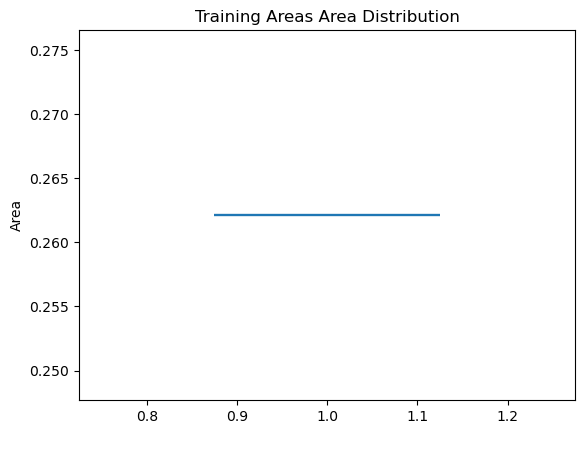

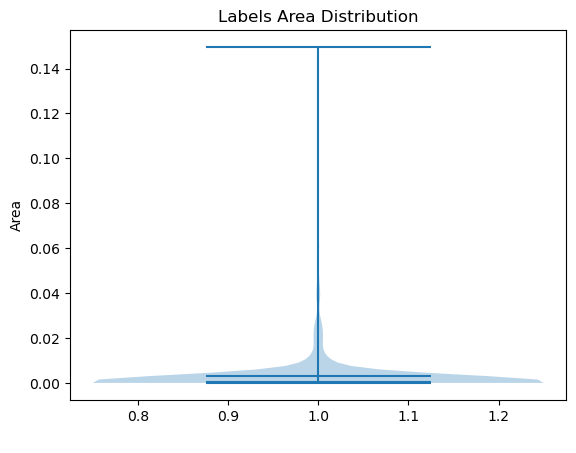


Percentage of training areas with labels: 44.75%

Total area of training areas: 104.85760000000002km²
Total area of labels: 2.234356677748208km²
Percentage of area covered by labels: 2.13%

--- Aerial/AE Labels ---
Number of training areas: 400
Number of labels: 46553

Training Areas Area Statistics:
count       400.0
mean     262144.0
std           0.0
min      262144.0
25%      262144.0
50%      262144.0
75%      262144.0
max      262144.0
Name: area, dtype: float64

Labels Area Statistics:
count    4.655300e+04
mean     4.101717e-05
std      1.068520e-03
min      9.081716e-08
25%      3.422635e-07
50%      1.441445e-06
75%      4.162241e-06
max      1.173978e-01
Name: area, dtype: float64


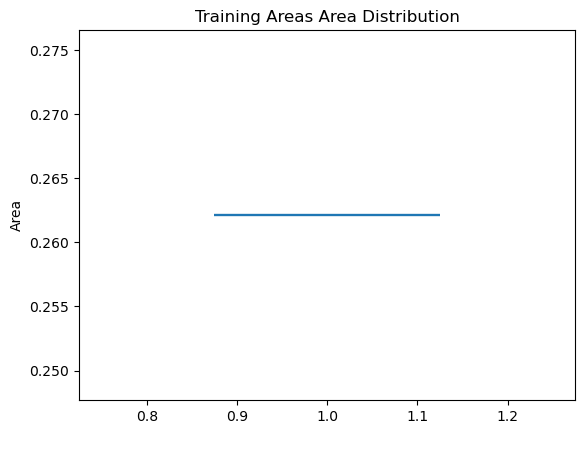

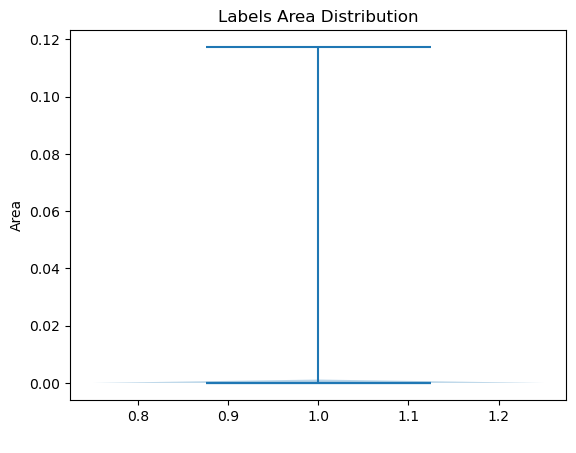


Percentage of training areas with labels: 72.25%

Total area of training areas: 104.85760000000002km²
Total area of labels: 1.9094725458891464km²
Percentage of area covered by labels: 1.82%

--- PlanetScope Labels ---


DataSourceError: \\smb.isipd.dmawi.de\projects\p_planetdw\data\methods_test\training\PS\labels_PS.gpkg: No such file or directory

In [1]:
import geopandas as gpd
from matplotlib import pyplot as plt

TRAINING_AREAS = r"\\smb.isipd.dmawi.de\projects\p_planetdw\data\methods_test\training\AE\training_areas.gpkg"

LABELS_S2 = r"\\smb.isipd.dmawi.de\projects\p_planetdw\data\methods_test\training\S2\labels_S2_exp.gpkg"
LABELS_AE = r"\\smb.isipd.dmawi.de\projects\p_planetdw\data\methods_test\training\AE\labels_AE.gpkg"
LABELS_PS = r"\\smb.isipd.dmawi.de\projects\p_planetdw\data\methods_test\training\PS\labels_PS.gpkg"

def visualise_training_data(label_path: str, training_area_path: str):

    training_areas = gpd.read_file(training_area_path)
    labels = gpd.read_file(label_path)

    # print number of geometries in each file
    print(f"Number of training areas: {len(training_areas)}")
    print(f"Number of labels: {len(labels)}")

    # get area of each geometry
    training_areas["area"] = training_areas.geometry.area
    labels["area"] = labels.geometry.area / 1000000  # convert to km²

    # print statistics of the area of TAs and labels
    print("\nTraining Areas Area Statistics:")
    print(training_areas["area"].describe())
    print("\nLabels Area Statistics:")
    print(labels["area"].describe())

    training_areas["area"] = training_areas["area"] / 1000000  # convert to km²

    # plot distribution of areas
    plt.violinplot(training_areas["area"], vert=True, showmeans=True, showmedians=True)
    plt.ylabel("Area")
    #remove x label
    plt.xlabel(' ')
    plt.title("Training Areas Area Distribution")
    plt.show()

    plt.violinplot(labels["area"], vert=True, showmeans=True, showmedians=True)
    plt.ylabel("Area")
    plt.xlabel(' ')
    plt.title("Labels Area Distribution")
    plt.show()

    # print percentage of tas which have labels within them
    tas_with_labels = 0
    for idx, ta in training_areas.iterrows():
        ta_labels = labels[labels.within(ta.geometry)]
        if len(ta_labels) > 0:
            tas_with_labels += 1 
    print(f"\nPercentage of training areas with labels: {tas_with_labels / len(training_areas) * 100:.2f}%")

    # get total area of TAs and labels and print percentage of area covered by labels in relation to TAs, eg background vs labels
    total_ta_area = training_areas["area"].sum()
    total_label_area = labels["area"].sum()

    print(f"\nTotal area of training areas: {total_ta_area}km²")
    print(f"Total area of labels: {total_label_area}km²")
    print(f"Percentage of area covered by labels: {total_label_area / total_ta_area * 100:.2f}%")

print("\n--- Sentinel-2 Labels ---")
visualise_training_data(LABELS_S2, TRAINING_AREAS)

print("\n--- Aerial/AE Labels ---")
visualise_training_data(LABELS_AE, TRAINING_AREAS)

print("\n--- PlanetScope Labels ---")
visualise_training_data(LABELS_PS, TRAINING_AREAS)

found 400 training areas
data_split
training      29180
validation     9979
testing        8478
Name: count, dtype: int64


C:\Users\castad001\AppData\Local\Temp\ipykernel_20296\3505274706.py:272: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap(cmap_name)
C:\Users\castad001\AppData\Local\Temp\ipykernel_20296\3505274706.py:301: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
C:\Users\castad001\AppData\Local\Temp\ipykernel_20296\3505274706.py:329: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["train", "val", "test"])
C:\Users\castad001\AppData\Local\Temp\ipykernel_20296\3505274706.py:301: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will

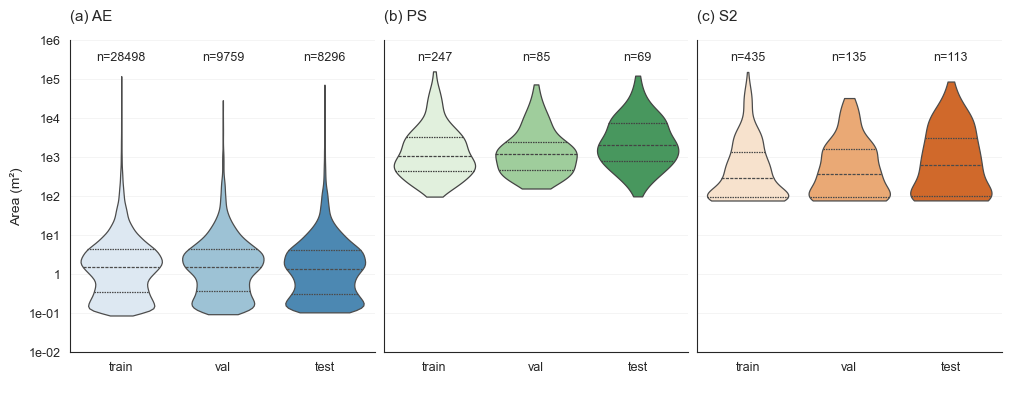

Saved plots: figs\area_violins_quartiles_countnorm_m2ticks.pdf and figs\area_violins_quartiles_countnorm_m2ticks.png
Saved: \\smb.isipd.dmawi.de\projects\p_planetdw\data\methods_test\training\AE\training_areas_with_split.gpkg


In [7]:
import json
from pathlib import Path
import re
from typing import Optional, List

import geopandas as gpd
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.transforms import blended_transform_factory
from matplotlib.ticker import FuncFormatter

import seaborn as sns


# ----------------------------
# USER OPTIONS (paper version)
# ----------------------------
# Leave empty => draw an empty PS subplot (but keep the 3-panel layout)
LABELS_PS = ""

# Violin KDE smoothing (1.0 default-ish; lower => less smooth, higher => more smooth)
BW_ADJUST = 1.0

TEXTOFF = 0.925

# ----------------------------
# PALETTE OPTIONS (CHOOSABLE CONSTANTS)
# ----------------------------
# Panel order (requested): AE, PS, S2
PANEL_ORDER = ["AE", "PS", "S2"]

# Matplotlib colormaps used per modality (change these to anything in mpl colormap list)
# Examples: "Blues", "Greens", "Oranges", "Purples", "viridis", "magma", "cividis", etc.
MODALITY_CMAPS = {
    "AE": "Blues",
    "PS": "Greens",
    "S2": "Oranges",
}

# Shade range sampled from each colormap for train/val/test (0..1)
# Lower -> lighter, higher -> darker
PALETTE_SHADE_MIN = 0.15
PALETTE_SHADE_MAX = 0.65

# Plot split order (keep as-is unless you change your splits)
SPLIT_ORDER = ["training", "validation", "testing"]

# ----------------------------
# Paths
# ----------------------------
TRAINING_AREAS = r"\\smb.isipd.dmawi.de\projects\p_planetdw\data\methods_test\training\AE\training_areas.gpkg"

LABELS_S2 = r"\\smb.isipd.dmawi.de\projects\p_planetdw\data\methods_test\training\S2\labels_S2_exp.gpkg"
LABELS_AE = r"\\smb.isipd.dmawi.de\projects\p_planetdw\data\methods_test\training\AE\labels_AE.gpkg"
LABELS_PS = r"\\smb.isipd.dmawi.de\projects\p_planetdw\data\methods_test\training\S2\labels_S2.gpkg"

DATA_SPLIT_AA = r"\\smb.isipd.dmawi.de\projects\p_planetdw\data\methods_test\preprocessed\20251226-0433_UNETxAE\aa_frames_list.json"

FIG_DIR = Path("figs")
FIG_DIR.mkdir(parents=True, exist_ok=True)
OUT_PDF = FIG_DIR / "area_violins_quartiles_countnorm_m2ticks.pdf"
OUT_PNG = FIG_DIR / "area_violins_quartiles_countnorm_m2ticks.png"

OUT_TRAINING_AREAS_SPLIT = (
    r"\\smb.isipd.dmawi.de\projects\p_planetdw\data\methods_test\training\AE\training_areas_with_split.gpkg"
)


# ----------------------------
# Helpers
# ----------------------------
def safe_read_labels(path: str, source: str) -> Optional[gpd.GeoDataFrame]:
    """Read a label file if path is non-empty. Return None if empty or read fails."""
    if path is None or str(path).strip() == "":
        return None
    try:
        gdf = gpd.read_file(path)
        if gdf is None or len(gdf) == 0:
            return None
        gdf = gdf.copy()
        gdf["source"] = source
        return gdf
    except Exception as e:
        print(f"[WARN] Could not read {source} labels from: {path}\n       {e}")
        return None


def make_valid(gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    """Best-effort geometry validity fix (works well with shapely>=2)."""
    gdf = gdf.copy()
    try:
        gdf["geometry"] = gdf.geometry.make_valid()
    except Exception:
        pass
    return gdf


def sci_compact(x: float) -> str:
    """
    Compact scientific formatting for tick labels:
      1e+03 -> 1e3
      1e+00 -> 1
    """
    if not np.isfinite(x) or x <= 0:
        return ""
    s = f"{x:.0e}"  # e.g. 1e+03
    s = s.replace("e+0", "e").replace("e+", "e").replace("e0", "")
    if re.fullmatch(r"-?\d+e0", s):
        s = s.replace("e0", "")
    return s


def empty_panel(ax, title: str, ns: List[int], ylabel: Optional[str] = None):
    ax.set_title(title, loc="left", pad=14)
    if ylabel:
        ax.set_ylabel(ylabel)

    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(["train", "val", "test"])
    ax.set_xlabel(" ")

    # n labels centered above each category
    trans = blended_transform_factory(ax.transData, ax.transAxes)
    for i, n in enumerate(ns):
        ax.text(
            i, TEXTOFF, f"n={n}",
            transform=trans, ha="center", va="bottom",
            fontsize=9, clip_on=False
        )

    ax.grid(True, axis="y", linewidth=0.6, alpha=0.25)
    ax.set_axisbelow(True)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.text(0.5, 0.5, "No data", transform=ax.transAxes,
            ha="center", va="center", alpha=0.6)


# ----------------------------
# Load labels (PS optional)
# ----------------------------
labels_s2 = safe_read_labels(LABELS_S2, "S2")
labels_ae = safe_read_labels(LABELS_AE, "AE")
labels_ps = safe_read_labels(LABELS_PS, "PS")  # None if empty

loaded = [g for g in (labels_s2, labels_ae, labels_ps) if g is not None]
if not loaded:
    raise RuntimeError("No label files could be loaded (S2/AE/PS).")

# Harmonize CRS across loaded layers (you said already UTM 8N)
base_crs = loaded[0].crs
for i in range(len(loaded)):
    if loaded[i].crs != base_crs:
        loaded[i] = loaded[i].to_crs(base_crs)

all_labels = gpd.GeoDataFrame(pd.concat(loaded, ignore_index=True), crs=base_crs)

# ----------------------------
# Load training areas and align CRS
# ----------------------------
training_areas = gpd.read_file(TRAINING_AREAS)
print(f"found {len(training_areas)} training areas")

if training_areas.crs != all_labels.crs:
    training_areas = training_areas.to_crs(all_labels.crs)

training_areas = training_areas.copy()
training_areas["training_area_id"] = training_areas.index.astype(int)

# Best-effort geometry fix
all_labels = make_valid(all_labels)
training_areas = make_valid(training_areas)

# Clip labels to training areas
all_labels_clipped = gpd.clip(all_labels, training_areas)

# Spatial join to attach training_area_id
all_labels_joined = gpd.sjoin(
    all_labels_clipped,
    training_areas[["training_area_id", "geometry"]],
    how="left",
    predicate="intersects",
)

# If overlapping training areas create duplicates, keep first match
if all_labels_joined.index.duplicated().any():
    all_labels_joined = all_labels_joined[~all_labels_joined.index.duplicated(keep="first")]

# Remove sjoin artifact columns
all_labels = all_labels_joined.drop(
    columns=[c for c in all_labels_joined.columns if c.startswith("index_")],
    errors="ignore",
)
all_labels["training_area_id"] = all_labels["training_area_id"].astype("Int64")

# ----------------------------
# Load split lists and assign split
# ----------------------------
with open(DATA_SPLIT_AA, "r") as f:
    aa_frames = json.load(f)

training_frames_list = aa_frames["training_frames"]
validation_frames_list = aa_frames["validation_frames"]
testing_frames_list = aa_frames["testing_frames"]

all_labels["data_split"] = "unknown"
all_labels.loc[all_labels["training_area_id"].isin(training_frames_list), "data_split"] = "training"
all_labels.loc[all_labels["training_area_id"].isin(validation_frames_list), "data_split"] = "validation"
all_labels.loc[all_labels["training_area_id"].isin(testing_frames_list), "data_split"] = "testing"

print(all_labels["data_split"].value_counts(dropna=False))

# ----------------------------
# Compute area (UTM => m²) and log10 transform for plotting
# ----------------------------
all_labels["area_m2"] = all_labels.geometry.area.astype(float)
all_labels.loc[all_labels["area_m2"] <= 0, "area_m2"] = np.nan

# Violin is drawn in log10 space (better behaved for heavy tails)
all_labels["log10_area_m2"] = np.log10(all_labels["area_m2"])

split_order = SPLIT_ORDER
sources_fixed = PANEL_ORDER
panel_labels = ["(a)", "(b)", "(c)"]

df_plot = all_labels.loc[
    all_labels["data_split"].isin(split_order) & np.isfinite(all_labels["log10_area_m2"]),
    ["source", "data_split", "log10_area_m2"],
].copy()

vals = df_plot["log10_area_m2"].to_numpy()
if len(vals) == 0:
    raise RuntimeError("No valid areas to plot (check geometry / split assignment).")

# Global y-lims in log10 units (full range; nothing cut off)
ymin = float(np.nanmin(vals))
ymax = float(np.nanmax(vals))
pad = 0.06 * max(1e-6, (ymax - ymin))
ymin_plot, ymax_plot = ymin - pad, ymax + pad

# Decade ticks (labels will be shown in m²)
kmin = int(np.floor(ymin_plot))
kmax = int(np.ceil(ymax_plot))
decade_ticks = np.arange(kmin, kmax + 1, 1)

# ----------------------------
# Plot styling (paper-ish)
# ----------------------------
mpl.rcParams.update({
    "font.size": 10,
    "axes.titlesize": 11,
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "axes.linewidth": 0.8,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
})

sns.set_style("white")

# ----------------------------
# MODALITY-SPECIFIC PALETTES
# ----------------------------
palettes_by_source = {}
for src in sources_fixed:
    cmap_name = MODALITY_CMAPS.get(src, "Greys")
    cmap = get_cmap(cmap_name)
    shades = cmap(np.linspace(PALETTE_SHADE_MIN, PALETTE_SHADE_MAX, 3))
    palettes_by_source[src] = {
        "training": shades[0],
        "validation": shades[1],
        "testing": shades[2],
    }

fig, axes = plt.subplots(1, 3, sharey=True, figsize=(10.0, 3.9), constrained_layout=True)

for ax, source, plab in zip(axes, sources_fixed, panel_labels):
    sub = df_plot[df_plot["source"] == source]
    title = f"{plab} {source}"

    # n centered above each violin (train/val/test)
    ns = [int((sub["data_split"] == sp).sum()) for sp in split_order]

    if sub.empty:
        empty_panel(ax, title, ns, ylabel="Area (m²)" if ax is axes[0] else None)
        ax.set_ylim(ymin_plot, ymax_plot)
        ax.set_yticks(decade_ticks)
        ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: sci_compact(10.0 ** y)))
        continue

    ax.set_title(title, loc="left", pad=14)

    split_palette = palettes_by_source[source]

    try:
        sns.violinplot(
            data=sub,
            x="data_split",
            y="log10_area_m2",
            order=split_order,
            palette=split_palette,
            inner="quartile",
            density_norm="count",
            cut=0,
            linewidth=0.9,
            bw_adjust=BW_ADJUST,
            ax=ax,
        )
    except TypeError:
        sns.violinplot(
            data=sub,
            x="data_split",
            y="log10_area_m2",
            order=split_order,
            palette=split_palette,
            inner="quartile",
            scale="count",
            cut=0,
            linewidth=0.9,
            bw_adjust=BW_ADJUST,
            ax=ax,
        )

    ax.set_xticklabels(["train", "val", "test"])
    ax.set_xlabel(" ")

    # n labels centered above each violin
    trans = blended_transform_factory(ax.transData, ax.transAxes)
    for i, n in enumerate(ns):
        ax.text(
            i, TEXTOFF, f"n={n}",
            transform=trans, ha="center", va="bottom",
            fontsize=9, clip_on=False
        )

    # Y axis: plotted in log10-space, but labeled in m²
    ax.set_ylim(ymin_plot, ymax_plot)
    ax.set_yticks(decade_ticks)
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: sci_compact(10.0 ** y)))

    ax.grid(True, axis="y", linewidth=0.6, alpha=0.25)
    ax.set_axisbelow(True)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

axes[0].set_ylabel("Area (m²)")

fig.savefig(OUT_PDF, bbox_inches="tight")
fig.savefig(OUT_PNG, dpi=450, bbox_inches="tight")
plt.show()

print(f"Saved plots: {OUT_PDF} and {OUT_PNG}")

# ----------------------------
# Save training areas with split attribute
# ----------------------------
training_areas_out = training_areas.copy()
training_areas_out["data_split"] = "unknown"
training_areas_out.loc[training_areas_out["training_area_id"].isin(training_frames_list), "data_split"] = "training"
training_areas_out.loc[training_areas_out["training_area_id"].isin(validation_frames_list), "data_split"] = "validation"
training_areas_out.loc[training_areas_out["training_area_id"].isin(testing_frames_list), "data_split"] = "testing"

training_areas_out.to_file(OUT_TRAINING_AREAS_SPLIT)
print(f"Saved: {OUT_TRAINING_AREAS_SPLIT}")
